In [ ]:
# === 1. Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import random
import requests
from tqdm import tqdm
from shutil import move

# === 2. Setup Paths ===
root_dir = "/content/drive/MyDrive/openimages_dataset"
os.makedirs(root_dir, exist_ok=True)
for split in ["train", "val"]:
    for category in ["harmful", "safe"]:
        os.makedirs(os.path.join(root_dir, split, category), exist_ok=True)

# # === 3. Download Metadata ===
!wget https://storage.googleapis.com/openimages/v6/oidv6-class-descriptions.csv
!wget https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv

# === 4. Load Metadata ===
classes_df = pd.read_csv('oidv6-class-descriptions.csv', header=None)
classes_df.columns = ['LabelName', 'ClassName']

bbox_df = pd.read_csv('oidv6-train-annotations-bbox.csv')

# === 5. User Input: Classes ===

harmful_classes = [
    "Explosion", "Bomber", "Bloodhound", "Blood", "Guided missile destroyer",
    "Bombyliidae", "Fire", "Sniper rifle", "Injury", "Explosive material",
    "Knife throwing", "Gun", "Gunshot", "Firearm", "Knife", "Missile",
    "Machine gun", "Explosive weapon", "Rifle", "Shotgun", "Weapon",
    "Violence", "Death", "Bomb", "Handgun", "Assault rifle", "Accident"
]

safe_classes = ["Apple", "Animal", "Artichoke", "Auto part", "Bagel", "Baked goods",
    "Aircraft", "Alarm clock", "Ant", "Ball", "Balloon", "Bathroom cabinet",
    "Bear", "Bell pepper", "Baseball glove", "Cat", "Dog", "Horse", "Bird",
    "Chair", "Table", "Tree", "Person", "Car", "Bicycle",
    "Mountain","River","Smiling"]

max_images_per_category = 7500  # <<< tweak to fit ~2GB budget

# === 6. Find Label Codes ===
harmful_codes = classes_df[classes_df['ClassName'].isin(harmful_classes)]['LabelName'].tolist()
safe_codes = classes_df[classes_df['ClassName'].isin(safe_classes)]['LabelName'].tolist()

# === 7. Find Image IDs ===
def get_image_ids(label_codes):
    return bbox_df[bbox_df['LabelName'].isin(label_codes)]['ImageID'].unique().tolist()

harmful_image_ids = get_image_ids(harmful_codes)
safe_image_ids = get_image_ids(safe_codes)

# Shuffle and limit
random.shuffle(harmful_image_ids)
random.shuffle(safe_image_ids)
harmful_image_ids = harmful_image_ids[:max_images_per_category]
safe_image_ids = safe_image_ids[:max_images_per_category]

# === 8. Download Images ===
def download_images(image_ids, label):
    for image_id in tqdm(image_ids, desc=f"Downloading {label}"):
        url = f"https://open-images-dataset.s3.amazonaws.com/train/{image_id}.jpg"
        split = "train" if random.random() < 0.8 else "val"
        save_path = os.path.join(root_dir, split, label, f"{image_id}.jpg")
        try:
            r = requests.get(url, timeout=10)
            if r.status_code == 200:
                with open(save_path, 'wb') as f:
                    f.write(r.content)
        except Exception as e:
            print(f"Failed to download {image_id}: {e}")

download_images(harmful_image_ids, "harmful")
download_images(safe_image_ids, "safe")

# === 9. ✅ Done! ===
print("✅ All images downloaded and split into train/val folders!")


Mounted at /content/drive
--2025-05-02 17:51:08--  https://storage.googleapis.com/openimages/v6/oidv6-class-descriptions.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 459351 (449K) [text/csv]
Saving to: ‘oidv6-class-descriptions.csv’

oidv6-class-descrip 100%[===================>] 448.58K  --.-KB/s    in 0.003s  

2025-05-02 17:51:08 (136 MB/s) - ‘oidv6-class-descriptions.csv’ saved [459351/459351]

--2025-05-02 17:51:09--  https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225844

✅ All images downloaded and split into train/val folders!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
    return total_size

# Example usage:
train_size = get_folder_size('/content/drive/MyDrive/openimages_dataset/train')
val_size = get_folder_size('/content/drive/MyDrive/openimages_dataset/val')

# train_size = get_folder_size('https://drive.google.com/drive/folders/1830X86vDZzbuKGE-RihGorr3_bLOyjsd?usp=drive_link')
# val_size = get_folder_size('https://drive.google.com/drive/folders/182l-dgwiCZldnIez4-wgEewGzg5Ezvbs?usp=drive_link')

# Print sizes in MB and GB
print(f"Training folder size: {train_size / (1024**2):.2f} MB ({train_size / (1024**3):.2f} GB)")
print(f"Validation folder size: {val_size / (1024**2):.2f} MB ({val_size / (1024**3):.2f} GB)")
print(f"Total dataset size: {(train_size + val_size) / (1024**2):.2f} MB ({(train_size + val_size) / (1024**3):.2f} GB)")

Training folder size: 4334.85 MB (4.23 GB)
Validation folder size: 1248.82 MB (1.22 GB)
Total dataset size: 5583.67 MB (5.45 GB)


In [ ]:
import os
import shutil
import random

# --- Paths ---
original_train_path = '/content/drive/MyDrive/openimages_dataset/train'
original_val_path = '/content/drive/MyDrive/openimages_dataset/val'

new_dataset_path = '/content/drive/MyDrive/openimages_dataset_small'

# Create new directories
for split in ['train', 'val']:
    for category in ['harmful', 'safe']:
        os.makedirs(os.path.join(new_dataset_path, split, category), exist_ok=True)

# --- How many images we want ---
target_per_class = 3400  # Half of 2GB total

# --- Function to copy limited images ---
def copy_limited_images(source_folder, dest_folder, limit):
    images = [img for img in os.listdir(source_folder) if img.endswith('.jpg')]
    random.shuffle(images)
    selected_images = images[:limit]

    for img in selected_images:
        shutil.copy(os.path.join(source_folder, img), os.path.join(dest_folder, img))

# --- Copy Train Images ---
copy_limited_images(os.path.join(original_train_path, 'harmful'), os.path.join(new_dataset_path, 'train', 'harmful'), target_per_class)
copy_limited_images(os.path.join(original_train_path, 'safe'), os.path.join(new_dataset_path, 'train', 'safe'), target_per_class)

# --- Copy Val Images ---
copy_limited_images(os.path.join(original_val_path, 'harmful'), os.path.join(new_dataset_path, 'val', 'harmful'), int(target_per_class * 0.2))
copy_limited_images(os.path.join(original_val_path, 'safe'), os.path.join(new_dataset_path, 'val', 'safe'), int(target_per_class * 0.2))

print("✅ Dataset trimmed to ~2GB with balanced classes!")


✅ Dataset trimmed to ~2GB with balanced classes!


In [ ]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            filepath = os.path.join(dirpath, filename)
            total_size += os.path.getsize(filepath)
    return total_size

def count_images(folder_path):
    image_count = 0
    for dirpath, _, filenames in os.walk(folder_path):
        image_count += len([f for f in filenames if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return image_count

# --- Paths ---
train_path = '/content/drive/MyDrive/openimages_dataset/train'
val_path = '/content/drive/MyDrive/openimages_dataset/val'
val_harmful = os.path.join(val_path, 'harmful')
val_safe = os.path.join(val_path, 'safe')

# --- Folder Sizes ---
train_size = get_folder_size(train_path)
val_size = get_folder_size(val_path)

# --- Image Counts ---
harmful_count = count_images(val_harmful)
safe_count = count_images(val_safe)

# --- Output ---
print(f"📦 Training folder size: {train_size / (1024**2):.2f} MB ({train_size / (1024**3):.2f} GB)")
print(f"📁 Validation folder size: {val_size / (1024**2):.2f} MB ({val_size / (1024**3):.2f} GB)")
print(f"🧾 Total dataset size: {(train_size + val_size) / (1024**2):.2f} MB ({(train_size + val_size) / (1024**3):.2f} GB)\n")

print(f"✅ Validation - Harmful images: {harmful_count}")
print(f"✅ Validation - Safe images: {safe_count}")
print(f"🧮 Total Validation Images: {harmful_count + safe_count}")


📦 Training folder size: 3172.59 MB (3.10 GB)
📁 Validation folder size: 792.83 MB (0.77 GB)
🧾 Total dataset size: 3965.41 MB (3.87 GB)

✅ Validation - Harmful images: 996
✅ Validation - Safe images: 1533
🧮 Total Validation Images: 2529


In [ ]:
# --- Imports ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from google.colab import drive

# --- Mount Drive ---
drive.mount('/content/drive')

# --- Setup Device ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# --- Define Simple Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# --- Load Datasets ---
train_dataset = ImageFolder('/content/drive/MyDrive/openimages_dataset_small/train', transform=transform)
test_dataset = ImageFolder('/content/drive/MyDrive/openimages_dataset_small/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# --- Define MobileNetV2 Model ---
model = models.mobilenet_v2(pretrained=True)

# Modify classifier for 2 classes
model.classifier[1] = nn.Linear(model.last_channel, 2)

model = model.to(device)
print("✅ MobileNetV2 model loaded and modified.")

# --- Define Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Training Loop ---
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}")

print("✅ Training complete.")

# --- Save Model ---
torch.save(model.state_dict(), "mobilenetv2_simple.pth")
print("✅ Model saved as 'mobilenetv2_simple.pth'")


In [ ]:
# --- Validation Function ---
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

model = model.load_state_dict(torch.load("mobilenetv2_simple.pth"))

def validate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # probability for harmful class

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except:
        roc_auc = None

    print(f"✅ Validation Accuracy: {acc:.4f}")
    print(f"✅ Validation Precision: {precision:.4f}")
    if roc_auc is not None:
        print(f"✅ Validation ROC-AUC: {roc_auc:.4f}")
    else:
        print("⚠️ ROC-AUC could not be calculated (only one class predicted).")

    return acc, precision, roc_auc

# --- Run Validation ---
validate_model(model, test_loader, device)

NameError: name 'model' is not defined

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Rebuild model architecture
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 2)
model = model.to(device)

# Load saved weights
model.load_state_dict(torch.load("mobilenetv2_simple.pth", map_location=device))
model.eval()

print("✅ Model loaded and ready for validation.")


✅ Model loaded and ready for validation.


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

val_dataset = ImageFolder('/content/drive/MyDrive/openimages_dataset_small/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


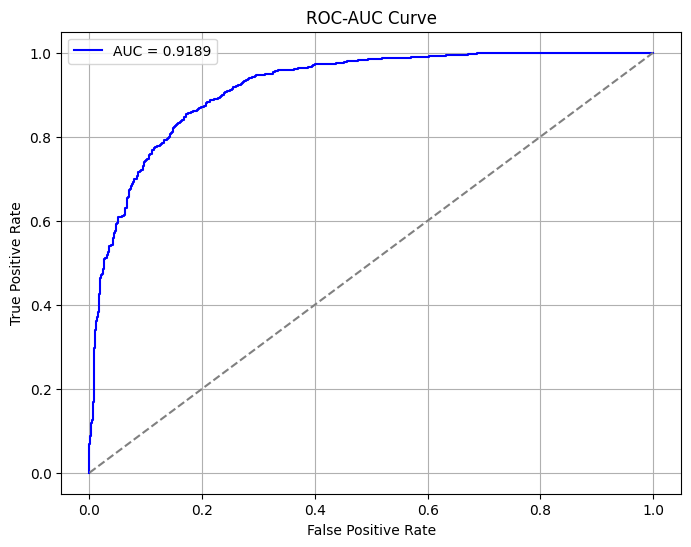

✅ Validation Accuracy: 0.8353
✅ Validation Precision: 0.8048
✅ Validation ROC-AUC: 0.9189


(0.8352941176470589, 0.8048128342245989, np.float64(0.9189381487889274))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def validate_model_with_auc_curve(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability for harmful class

    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)

    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
        fpr, tpr, _ = roc_curve(all_labels, all_probs)

        # Plot AUC Curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-AUC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        roc_auc = None
        print("⚠️ ROC-AUC could not be calculated:", e)

    print(f"✅ Validation Accuracy: {acc:.4f}")
    print(f"✅ Validation Precision: {precision:.4f}")
    if roc_auc is not None:
        print(f"✅ Validation ROC-AUC: {roc_auc:.4f}")

    return acc, precision, roc_auc

# --- Run It ---
validate_model_with_auc_curve(model, val_loader, device)

